# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pickle
import time
from reed import drop_missing_treatment_or_outcome, Model, transform_outcome

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)
   
### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

#### Parameters

In [2]:
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
load_from_cache=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

configuration_name = 'default'
outcome = 'y_wsce'#'y_wsce'
treatment = 'redufl'
test=True
data_file = "data/all_lasso_selected_100.csv"

In [3]:
# Parameters
configuration_name = "lasso-10"
outcome = "y_wsce"
treatment = "redufl"
test = False
data_file = "data/all_lasso_selected_10.csv"


In [4]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 50

cross_val_cache = f"data/cross-val-{configuration_name}.pkl"#"data/cross-val-all.pkl"
bootstrap_cache = f"data/bootstrap-{configuration_name}.pkl"#"data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


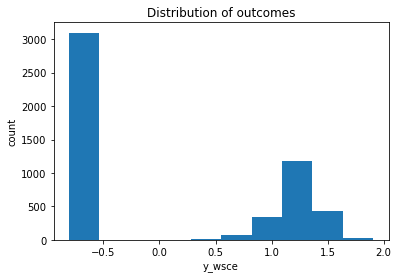

In [5]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [6]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,6)[1:],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# used for quick tests
def construct_test_models(): 
    models = [
        Model('Ridge',Ridge(),
              parameters = {'alpha':np.logspace(1,4,2)},
              importance_func=importance_from_coef
        ),
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,4)[1:],
              }
        ),
    ]
    return models

model_init = construct_test_models if test else construct_models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [7]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 10)
Treated data dimensions: (1368, 10)


### Compute unconditional/unadjusted estimate of treatment effect

In [8]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [9]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

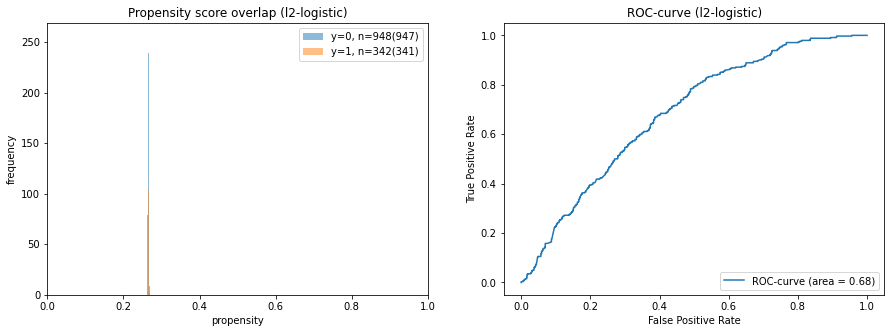

In [10]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [11]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
atcyng,DV: Age youngest own child (excl. resident foster/step),-0.004030,0.004030
ancage2,H3b Age of child - Non-resident child 0002,-0.002083,0.002083
awscef,DV: Imputation flag current weekly gross wages & salary - all jobs,0.001886,0.001886
awscme,"DV: Current weekly gross wages & salary, main job, includes estimated from net ($) [weighted top...",0.001017,0.001017
ahgsex,HF3 Sex,0.000943,0.000943
aicprob,H28 Is likely to have a child in the future,0.000899,0.000899
awsfe,"DV: Financial year gross wages & salary, includes estimated from net ($) [weighted topcode]",0.000743,0.000743
ajbmwpsz,E33 Number employed at place of work,0.000726,0.000726
ajbcasab,"DV: Casual worker (ABS definition: no paid holiday leave, no paid sick leave)",-0.000340,0.000340
ajbmo6s,"DV: AUSEI06 occupational status scale, current main job",0.000198,0.000198


In [12]:
from direct_regression import nested_cross_val

models0, models1, results = nested_cross_val(
    model_init,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=load_from_cache
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Caching results to data/cross-val-lasso-10.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,0.27,0.01,0.31,0.04,0.14,0.06,-0.64,0.04,-0.87,0.05
lasso,0.26,0.01,0.30,0.03,0.14,0.05,-0.64,0.03,-0.88,0.05
gbr,0.18,0.02,0.39,0.05,0.17,0.05,-0.56,0.03,-0.84,0.06


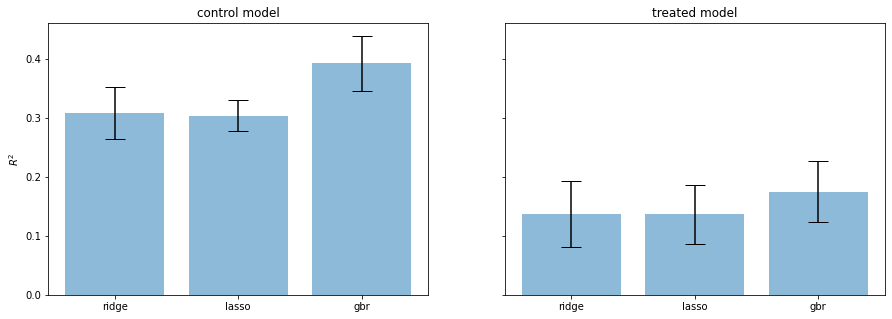

In [13]:
from direct_regression import visualise_ate
metrics, ate_vals = visualise_ate(results,X,evaluation_metrics);

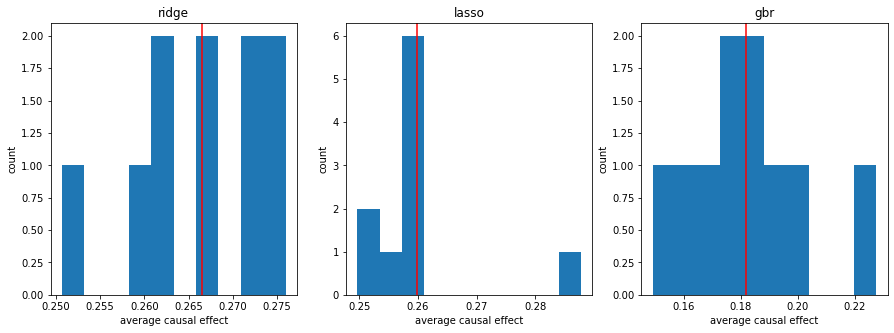

In [14]:
from direct_regression import plot_ate_distribution
plot_ate_distribution(ate_vals)

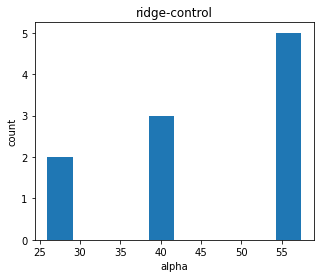

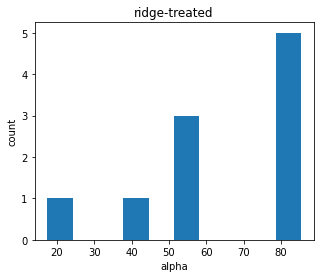

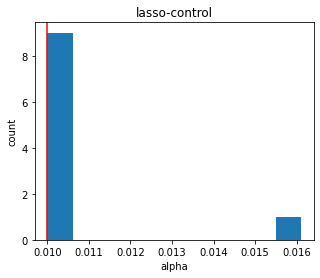

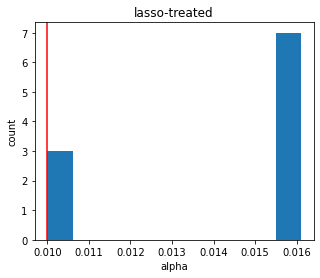

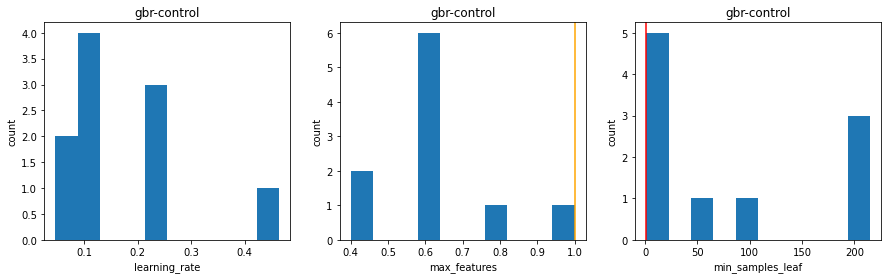

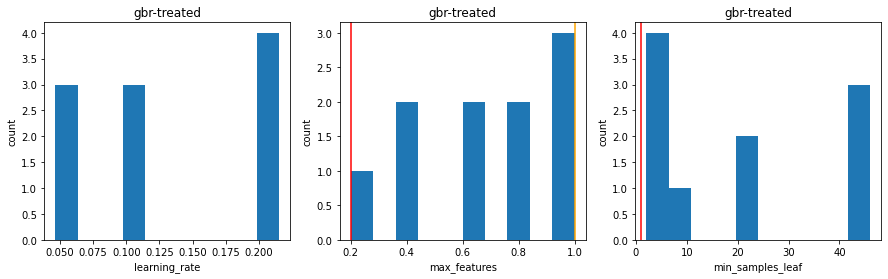

In [15]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [16]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
atcyng,0.434325,0.010650,0.018622,0.021214,-0.425014,0.020683,-0.443636,0.004908
aicprob,0.131723,0.005499,0.024824,0.005833,0.144134,0.006602,0.119311,0.005823
awscme,0.116416,0.011110,-0.127741,0.015937,0.052545,0.015152,0.180287,0.012012
ancage2,0.096313,0.008514,0.013630,0.012677,0.103129,0.013524,0.089498,0.006513
awsfe,0.041641,0.015940,0.009125,0.029028,0.046204,0.028881,0.037079,0.009767
ahgsex,0.031959,0.007141,-0.063918,0.014282,-0.037682,0.012523,0.026237,0.005788
ajbmo6s,0.031096,0.006835,0.062193,0.013669,0.028491,0.011391,-0.033702,0.006168
ajbmwpsz,0.024313,0.004650,0.021723,0.013909,0.035175,0.010742,0.013452,0.004958
ajbcasab,0.023626,0.004966,0.010014,0.008515,0.028633,0.007336,0.018619,0.005636


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
atcyng,0.436272,0.006243,-0.001743,0.013028,-0.437143,0.011671,-0.435400,0.005158
aicprob,0.125461,0.006712,0.029692,0.009205,0.140306,0.009255,0.110615,0.006842
awscme,0.115813,0.006939,-0.123614,0.015144,0.054006,0.010279,0.177621,0.010263
ancage2,0.082352,0.007903,0.012222,0.015045,0.088463,0.014497,0.076241,0.005286
awsfe,0.032273,0.015563,0.022889,0.027417,0.043718,0.027649,0.020829,0.009789
ahgsex,0.017063,0.008314,-0.034126,0.016629,-0.024587,0.012664,0.009539,0.007184
ajbmwpsz,0.016761,0.004799,0.018800,0.009822,0.026161,0.008712,0.007361,0.004290
ajbmo6s,0.016365,0.008133,0.032729,0.016266,0.020058,0.014483,-0.012671,0.006805
ajbcasab,0.015143,0.006701,0.015130,0.008355,0.022708,0.010088,0.007577,0.004791


### Compare against OLS on basic variables

In [17]:
basic = pd.read_csv("data/basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
basic[outcome] = transform_outcome(basic[outcome],log_outcome, standardize_outcome)

    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Dropped 284 rows missing treatment or outcome.
Fitting OLS ...Done
Caching results to data/tmp.pkl


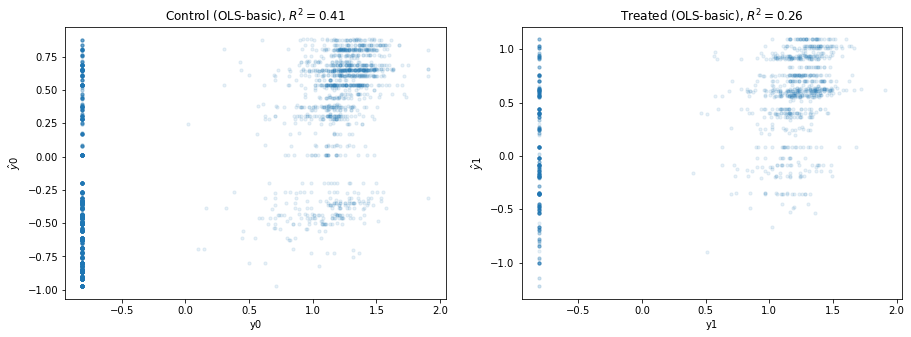

In [18]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


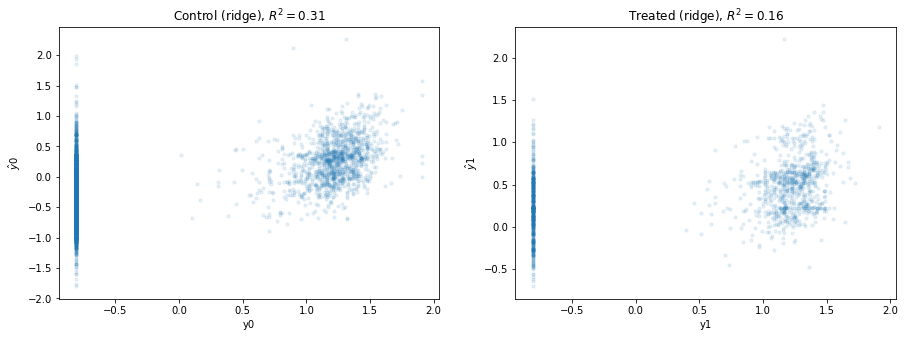

In [19]:
if 'ridge' in results.keys():
    y0a = results['ridge'][0]['estimator'][4].predict(X0)
    y1a = results['ridge'][1]['estimator'][4].predict(X1)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y0, y0a,s=10,alpha=0.1)
    ax[0].set_xlabel('y0')
    ax[0].set_ylabel('$\\hat{y}0$');
    ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

    ax[1].scatter(y1, y1a,s=10,alpha=0.1)
    ax[1].set_xlabel('y1')
    ax[1].set_ylabel('$\\hat{y}1$');
    ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)
# despite there being so few variables

In [20]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    model_init,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=load_from_cache,
    samples=bootstrap_samples
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Total time:2711.2377123832703 seconds
Caching results to: data/bootstrap-lasso-10.pkl


####  Average treatment effects

In [21]:
from direct_regression import compute_ate
metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
metrics

,ACE,ACE_std
ridge,0.261132,0.032933
lasso,0.259461,0.035565
gbr,0.190917,0.032839


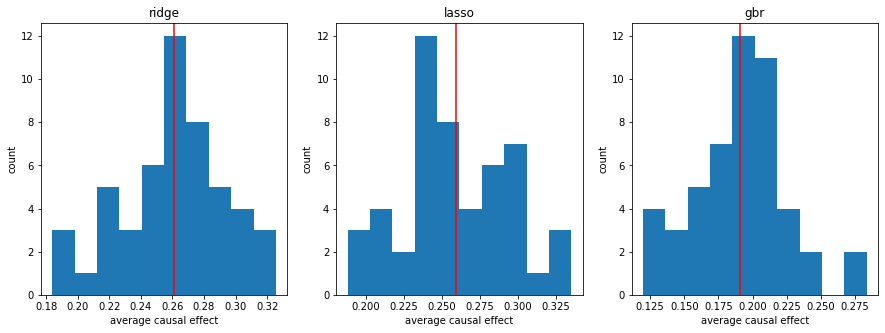

In [22]:
plot_ate_distribution(tau_estimatesb)

#### Distribution of hyper-parameters

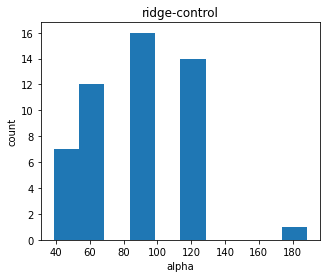

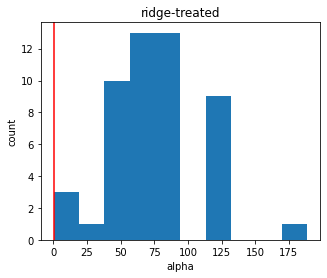

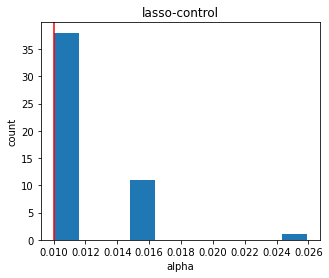

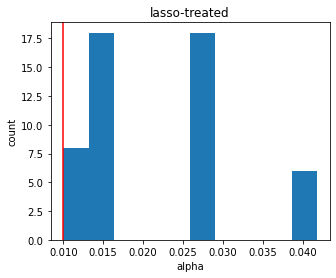

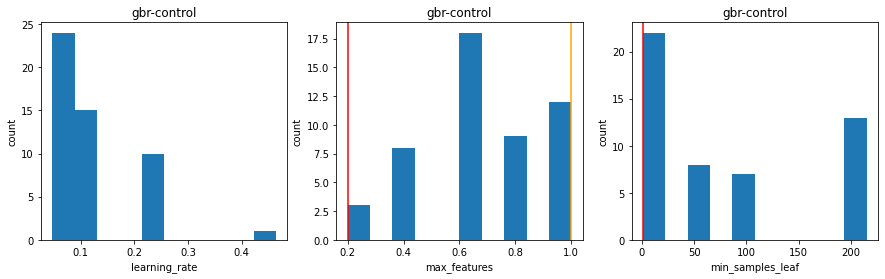

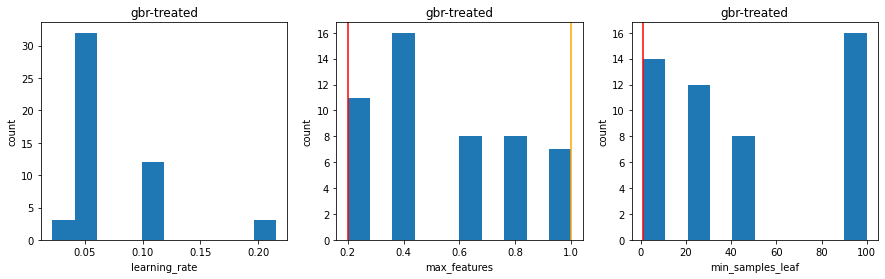

In [23]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")